In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from algorithm import approx_prox_sub_newton, prox_newton
from logistic_setup import F_logistic, f_logistic, f_logistic_grad, f_logistic_hess_z, prox_h
from fista import fista

np.random.seed(0)

## Experiment with synthetic data
1. constant stepsizes, with subsampled gradient: critierion (vs cri_lee) vs predefined precision
stepsizes chosen from \{2**-k\}

In [32]:
# generate data, do not run it again!
from sklearn.preprocessing import normalize

X_50 = np.random.randn(10000, 50)
y_50 = np.random.randint(2, size=10000)
X_50 = normalize(X_50, axis=1, norm='l2')
# np.savez('datasets/data_10000_50.npz', X=X_50, y=y_50)

X_500 = np.random.randn(10000, 500)
y_500 = np.random.randint(2, size=10000)
X_500 = normalize(X_500, axis=1, norm='l2')
# np.savez('datasets/data_10000_500.npz', X=X_500, y=y_500)

X_5000 = np.random.randn(10000, 5000)
y_5000 = np.random.randint(2, size=10000)
X_5000 = normalize(X_5000, axis=1, norm='l2')
# np.savez('datasets/data_10000_5000.npz', X=X_5000, y=y_5000)

KeyboardInterrupt: 

In [3]:
# use fista to derive optimal values, do not run it again!

# set lambda and mu
lam = 1e-3
mu = 1e-3

# define grad_function given dataset X, y, mu
grad_50 = partial(f_logistic_grad, X=X_50, y=y_50, mu=mu)
grad_500 = partial(f_logistic_grad, X=X_500, y=y_500, mu=mu)
grad_5000 = partial(f_logistic_grad, X=X_5000, y=y_5000, mu=mu)

# Apply FISTA to solve the original problem
x_init_50 = np.ones(X_50.shape[1])
x_init_500 = 0.1 * np.ones(X_500.shape[1])
x_init_5000 = 0.01 * np.ones(X_5000.shape[1])

options = {'stopping': '', 'threshold': 1e-12, 'max_iter': 10000, 'store_seq': False}

x_50_opt, _ = fista(grad_50, 1, lam, x_init_50, options)
x_500_opt, _ = fista(grad_500, 1, lam, x_init_500, options)
x_5000_opt, _ = fista(grad_5000, 1, lam, x_init_5000, options)

loss_50_opt = F_logistic(x_50_opt, X_50, y_50, mu, lam)
loss_500_opt = F_logistic(x_500_opt, X_500, y_500, mu, lam)
loss_5000_opt = F_logistic(x_5000_opt, X_5000, y_5000, mu, lam)

# np.savez('sequences/synthetic_10000_optimal_50_500_5000.npz', x1=x_50_opt, x2=x_500_opt, x3=x_5000_opt, loss1=loss_50_opt, loss2=loss_500_opt, loss3=loss_5000_opt)

In [33]:
# load three synthetic data
data1 = np.load('datasets/data_10000_50.npz')
X1 = data1['X']
y1 = data1['y']
L1 = np.max(np.linalg.norm(X1, axis=1, ord=2)**2)

data2 = np.load('datasets/data_10000_500.npz')
X2 = data2['X']
y2 = data2['y']
L2 = np.max(np.linalg.norm(X2, axis=1, ord=2)**2)

data3 = np.load('datasets/data_10000_5000.npz')
X3 = data3['X']
y3 = data3['y']
L3 = np.max(np.linalg.norm(X3, axis=1, ord=2)**2)

L1, L2, L3, X1.shape

(1.0000000000000004, 1.0000000000000013, 1.0000000000000044, (10000, 50))

In [34]:
# set lambda and mu, and x_init
lam = 1e-3
mu = 1e-3
x_init_1 = np.ones(X1.shape[1])
x_init_2 = 0.1 * np.ones(X2.shape[1])
x_init_3 = 0.1 * np.ones(X3.shape[1])

# load optimal value
data = np.load('sequences/synthetic_10000_optimal_50_500_5000.npz')
x1_star = data['x1']
x2_star = data['x2']
x3_star = data['x3']
loss1_star = data['loss1']
loss2_star = data['loss2']
loss3_star = data['loss3']

In [ ]:
# Apply FISTA to solve the original problem (for check purpose!!!)

# define grad_function given dataset X, y, mu
grad = partial(f_logistic_grad, X=X1, y=y1, mu=mu)
obj = partial(F_logistic, X=X1, y=y1, mu=mu, lam=lam)

options_1_fista = {'stopping': '', 'threshold': 1e-8, 'max_iter': 1000, 'store_seq': True}

x_1_fista, iter_num1 = fista(grad, L1, lam, x_init_1, options_1_fista)
loss_1_fista = np.apply_along_axis(obj, axis=1, arr=x_1_fista)

plt.plot(loss_1_fista-loss1_star)
plt.yscale('log')
plt.show()

In [35]:
# Apply the approximate proximal subsampled Newton method
opts1_cri = {'stopping': 'criteria', 'threshold': 10, 'inner_max': 200, 'grad_size': {'init': 0.01, 'growth': 1.1, 'period': 5}, 'hess_size': {'init': 0.05, 'growth': 1, 'period': 10}}
opts1_acc = {'stopping': '', 'threshold': 1e-8, 'inner_max': 200, 'grad_size': {'init': 0.01, 'growth': 1.1, 'period': 5}, 'hess_size': {'init': 0.05, 'growth': 1, 'period': 10}}

In [36]:
loss1, w1, inner_num1 = approx_prox_sub_newton(X=X1, y=y1, mu=mu, lam=lam, w_init=x_init_1, lr=2**-1, opts=opts1_cri, iter_num=250)
loss1_acc, w1_acc, inner_num1_acc = approx_prox_sub_newton(X=X1, y=y1, mu=mu, lam=lam, w_init=x_init_1, lr=2**-1, opts=opts1_acc, iter_num=250)

100%|██████████| 250/250 [00:53<00:00,  4.64it/s]


In [37]:
loss2, w2, inner_num2 = approx_prox_sub_newton(X=X2, y=y2, mu=mu, lam=lam, w_init=x_init_2, lr=2**-2, opts=opts1_cri, iter_num=250)
loss2_acc, w2_acc, inner_num2_acc = approx_prox_sub_newton(X=X2, y=y2, mu=mu, lam=lam, w_init=x_init_2, lr=2**-2, opts=opts1_acc, iter_num=250)

100%|██████████| 250/250 [03:13<00:00,  1.29it/s]


In [39]:
loss3, w3, inner_num3 = approx_prox_sub_newton(X=X3, y=y3, mu=mu, lam=lam, w_init=x_init_3, lr=2**-4, opts=opts1_cri, iter_num=250)
loss3_acc, w3_acc, inner_num3_acc = approx_prox_sub_newton(X=X3, y=y3, mu=mu, lam=lam, w_init=x_init_3, lr=2**-4, opts=opts1_acc, iter_num=250)

100%|██████████| 250/250 [15:36<00:00,  3.74s/it]


In [41]:
np.savez('sequences/synthetic_10000_5000_loss_inner.npz', loss=loss3, w=w3, inner_num=inner_num3, loss_acc=loss3_acc, w_acc=w3_acc, inner_num_acc=inner_num3_acc)
# data = np.load('sequences/synthetic_10000_5000_loss_inner.npz')
# loss3 = data['loss']
# w3 = data['w']
# inner_num3 = data['inner_num']
# loss3_acc = data['loss_acc']
# w3_acc = data['w_acc']
# inner_num3_acc = data['inner_num_acc']

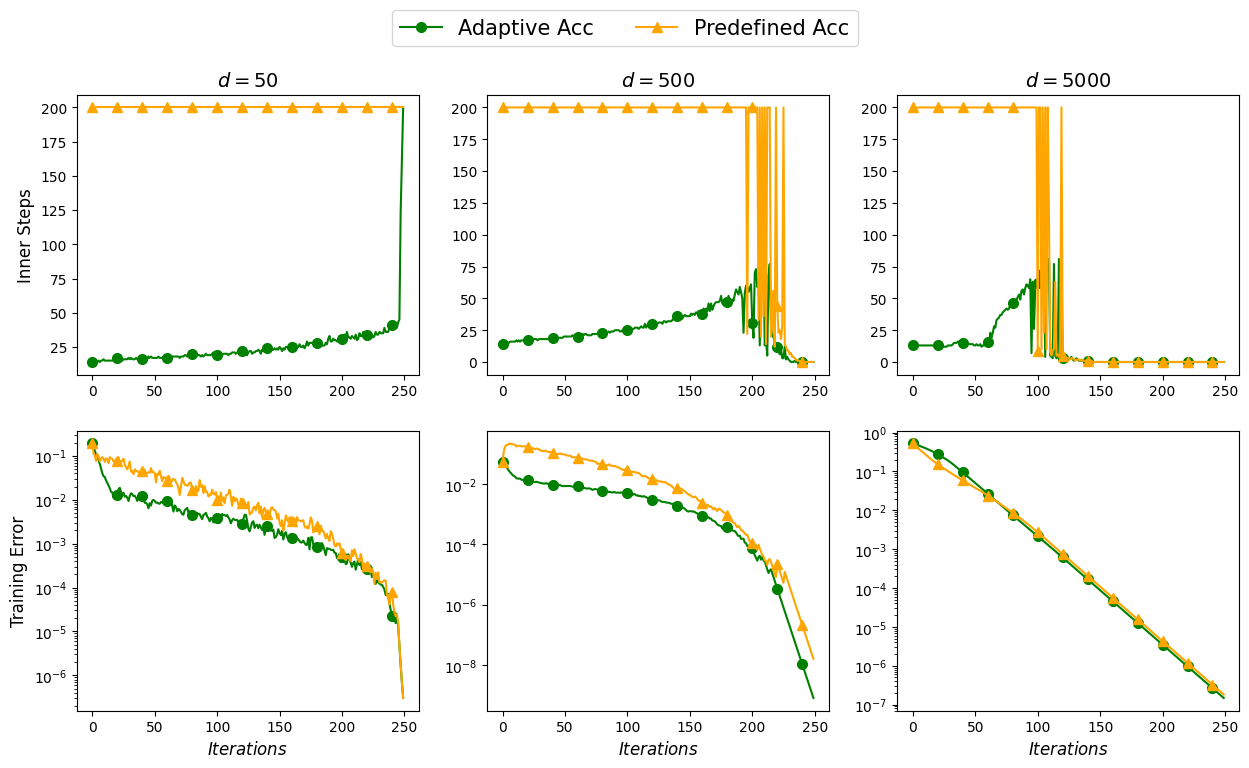

In [40]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax[0, 0].plot(inner_num1, color='green', marker='o', label='Adaptive Acc', markersize=7, markevery=20)
ax[0, 0].plot(inner_num1_acc, color='orange', marker='^', label='Predefined Acc', markersize=7, markevery=20)
# ax[0, 0].legend(fontsize=12)
ax[0, 0].set_ylabel('Inner Steps', fontsize=12)
ax[0, 0].set_title(r'$d=50$', fontsize=14)
ax[0, 1].plot(inner_num2, color='green', marker='o', markersize=7, markevery=20)
ax[0, 1].plot(inner_num2_acc, color='orange', marker='^', markersize=7, markevery=20)
# ax[0, 1].legend(fontsize=12)
ax[0, 1].set_title(r'$d=500$', fontsize=14)
ax[0, 2].plot(inner_num3, color='green', marker='o', markersize=7, markevery=20)
ax[0, 2].plot(inner_num3_acc, color='orange', marker='^', markersize=7, markevery=20)
# ax[0, 2].legend(fontsize=12)
ax[0, 2].set_title(r'$d=5000$', fontsize=14)
ax[1, 0].plot(loss1 - loss1_star, color='green', marker='o', markersize=7, markevery=20)
ax[1, 0].plot(loss1_acc - loss1_star, color='orange', marker='^', markersize=7, markevery=20)
ax[1, 0].set_yscale('log')
# ax[1, 0].legend(fontsize=12)
ax[1, 0].set_ylabel('Training Error', fontsize=12)
ax[1, 0].set_xlabel(r'$Iterations$', fontsize=12)
ax[1, 1].plot(loss2 - loss2_star, color='green', marker='o', markersize=7, markevery=20)
ax[1, 1].plot(loss2_acc - loss2_star, color='orange', marker='^', markersize=7, markevery=20)
ax[1, 1].set_yscale('log')
# ax[1, 1].legend(fontsize=12)
ax[1, 1].set_xlabel(r'$Iterations$', fontsize=12)
ax[1, 2].plot(loss3 - loss3_star, color='green', marker='o', markersize=7, markevery=20)
ax[1, 2].plot(loss3_acc - loss3_star, color='orange', marker='^', markersize=7, markevery=20)
ax[1, 2].set_yscale('log')
# ax[1, 2].legend(fontsize=12)
ax[1, 2].set_xlabel(r'$Iterations$', fontsize=12)
# apply seaborn style
# plt.style.use('seaborn')
fig.legend(loc='upper center', ncol=2, fontsize=15)
plt.savefig('images/synthetic_test.png')
plt.show()

## Experiment with real data

In [3]:
# load real datasets
import pickle
from sklearn.datasets import load_svmlight_file
from scipy.sparse.linalg import norm
from scipy.sparse import hstack
from sklearn.preprocessing import normalize

# covtype = load_svmlight_file('./datasets/covtype.libsvm.binary.scale')
# X_cov = covtype[0]
# X_cov = normalize(X_cov, axis=1, norm='l2')
# L_cov = np.max(norm(X_cov, ord=2, axis=1) ** 2)
# y_cov = covtype[1]
# y_cov[y_cov == 2] = 0

rcv1 = pickle.load(open("datasets/rcv1_X_y.p", "rb"))
X_rcv = rcv1[0]  # L2 normlized
L_rcv = np.max(norm(X_rcv, ord=2, axis=1) ** 2)
y_rcv = rcv1[1]
y_rcv[y_rcv == 3] = 1
y_rcv[y_rcv == 2] = 0
np.sum(y_rcv)/len(y_rcv)

a9a = load_svmlight_file('./datasets/a9a_train.libsvm')
X_a9a = a9a[0]
X_a9a = normalize(X_a9a, axis=1, norm='l2')
L_a9a = np.max(norm(X_a9a, ord=2, axis=1) ** 2)
y_a9a = a9a[1]
y_a9a[y_a9a == -1] = 0
a9a_test = load_svmlight_file('./datasets/a9a_test.libsvm')
X_a9a_t = a9a_test[0]
y_a9a_t = a9a_test[1]
y_a9a_t[y_a9a_t == -1] = 0
zero_col = np.zeros((X_a9a_t.shape[0], 1))
X_a9a_t = hstack((X_a9a_t, zero_col))

w8a = load_svmlight_file('./datasets/w8a_train.libsvm')
X_w8a = w8a[0]
X_w8a = normalize(X_w8a, axis=1, norm='l2')
L_w8a = np.max(norm(X_w8a, ord=2, axis=1) ** 2)
y_w8a = w8a[1]
y_w8a[y_w8a == -1] = 0
w8a_test = load_svmlight_file('./datasets/w8a_test.libsvm')
X_w8a_t = w8a_test[0]
y_w8a_t = w8a_test[1]
y_w8a_t[y_w8a_t == -1] = 0

mushroom = load_svmlight_file('./datasets/mushrooms.libsvm')
X_mush = mushroom[0]
X_mush = normalize(X_mush, axis=1, norm='l2')
L_mush = np.max(norm(X_mush, ord=2, axis=1) ** 2)
y_mush = mushroom[1]
y_mush[y_mush == 1] = 0
y_mush[y_mush == 2] = 1

L_rcv, L_a9a, L_w8a, L_mush
# X_rcv.shape, X_a9a.shape, X_w8a.shape, X_mush.shape
# X_mush

(1.0000000000000044, 1.0, 1.0000000000000004, 1.0)

In [4]:
# set lambda and mu
lam = 1e-3
mu = 1e-3

# define grad_function given dataset X, y, mu for FISTA
# grad_cov = partial(f_logistic_grad, X=X_cov, y=y_cov, mu=mu)
grad_rcv = partial(f_logistic_grad, X=X_rcv, y=y_rcv, mu=mu)
grad_a9a = partial(f_logistic_grad, X=X_a9a, y=y_a9a, mu=mu)
grad_w8a = partial(f_logistic_grad, X=X_w8a, y=y_w8a, mu=mu)
grad_mush = partial(f_logistic_grad, X=X_mush, y=y_mush, mu=mu)


In [88]:
# use fista to derive optimal values, do not run it again!

# set initial points
# x_init_cov = np.ones(X_cov.shape[1])/(X_cov.shape[1]/50)
# x_init_rcv = np.ones(X_rcv.shape[1])/(X_rcv.shape[1]/50)
x_init_a9a = np.ones(X_a9a.shape[1])/(X_a9a.shape[1]/50)
x_init_w8a = np.ones(X_w8a.shape[1])/(X_w8a.shape[1]/50)
x_init_mush = np.ones(X_mush.shape[1])/(X_mush.shape[1]/50)

options = {'stopping': '', 'threshold': 1e-12, 'max_iter': 10000, 'store_seq': False}

# X_cov_opt, _ = fista(grad_cov, L_cov, lam, x_init_cov, options)
# x_rcv_opt, _ = fista(grad_rcv, L_rcv, lam, x_init_rcv, options)
x_a9a_opt, _ = fista(grad_a9a, L_a9a, lam, x_init_a9a, options)
x_w8a_opt, _ = fista(grad_w8a, L_w8a, lam, x_init_w8a, options)
x_mush_opt, _ = fista(grad_mush, L_mush, lam, x_init_mush, options)

# loss_cov_opt = F_logistic(X_cov_opt, X_cov, y_cov, mu, lam)
# loss_rcv_opt = F_logistic(x_rcv_opt, X_rcv, y_rcv, mu, lam)
loss_a9a_opt = F_logistic(x_a9a_opt, X_a9a, y_a9a, mu, lam)
loss_w8a_opt = F_logistic(x_w8a_opt, X_w8a, y_w8a, mu, lam)
loss_mush_opt = F_logistic(x_mush_opt, X_mush, y_mush, mu, lam)

# np.savez('sequences/covtype_optimal.npz', x_star=X_cov_opt, loss_star=loss_cov_opt)
# np.savez('sequences/rcv_optimal.npz', x_star=x_rcv_opt, loss_star=loss_rcv_opt)
np.savez('sequences/a9a_optimal.npz', x_star=x_a9a_opt, loss_star=loss_a9a_opt)
np.savez('sequences/w8a_optimal.npz', x_star=x_w8a_opt, loss_star=loss_w8a_opt)
# np.savez('sequences/mush_optimal.npz', x_star=x_mush_opt, loss_star=loss_mush_opt)

In [5]:
# set lambda and mu, and x_init
lam = 1e-3
mu = 1e-3
# x_init_cov = 0.1*np.ones(X_cov.shape[1])
x_init_rcv = 0.1*np.ones(X_rcv.shape[1])
x_init_a9a = 0.1*np.ones(X_a9a.shape[1])
x_init_w8a = 0.1*np.ones(X_w8a.shape[1])
x_init_mush = 0.1*np.ones(X_mush.shape[1])

# load optimal value
# opt_cov = np.load('sequences/covtype_optimal.npz')
opt_rcv = np.load('sequences/rcv_optimal.npz')
opt_a9a = np.load('sequences/a9a_optimal.npz')
opt_w8a = np.load('sequences/w8a_optimal.npz')
opt_mush = np.load('sequences/mush_optimal.npz')

# X_cov_opt = opt_cov['x_star']
# loss_cov_opt = opt_cov['loss_star']

x_rcv_star = opt_rcv['x_star']
loss_rcv_star = opt_rcv['loss_star']

x_a9a_star = opt_a9a['x_star']
loss_a9a_star = opt_a9a['loss_star']

x_w8a_star = opt_w8a['x_star']
loss_w8a_star = opt_w8a['loss_star']

x_mush_star = opt_mush['x_star']
loss_mush_star = opt_mush['loss_star']

### Draw a table recording different inner accuracy, w.r.t., (desired loss, # outer iterations, # average inner iterations)

In [16]:
# set lambda and mu, and x_init
from torch import threshold


lam = 1e-3
mu = 1e-3
x_init_cov = np.ones(X_cov.shape[1])

# choose option set
acc_list = [10**-k for k in range(4, 11, 2)]
threshold_list = [0.1, 0.5, 1, 10]
opts_cri_list = []
for thresh in threshold_list:
    opts_cri_list.append({'stopping': 'criteria', 'threshold': thresh, 'inner_max': 1000, 'grad_size': {'init': 0.02, 'growth': 1.1, 'period': 5}, 'hess_size': {'init': 0.01, 'growth': 1, 'period': 10}})
opts_acc_list = []
for acc in acc_list:
    opts_acc_list.append({'stopping': '', 'threshold': acc, 'inner_max': 1000, 'grad_size': {'init': 0.02, 'growth': 1.1, 'period': 5}, 'hess_size': {'init': 0.01, 'growth': 1, 'period': 10}})

In [17]:
loss_cov_1, w_cov_1, inner_num_cov_1 = approx_prox_sub_newton(X=X_cov, y=y_cov, mu=mu, lam=lam, w_init=x_init_cov, lr=2**-2, opts=opts_cri_list[0], iter_num=21)
loss_cov_2, w_cov_2, inner_num_cov_2 = approx_prox_sub_newton(X=X_cov, y=y_cov, mu=mu, lam=lam, w_init=x_init_cov, lr=2**-2, opts=opts_cri_list[1], iter_num=24)
loss_cov_3, w_cov_3, inner_num_cov_3 = approx_prox_sub_newton(X=X_cov, y=y_cov, mu=mu, lam=lam, w_init=x_init_cov, lr=2**-2, opts=opts_cri_list[2], iter_num=26)
loss_cov_4, w_cov_4, inner_num_cov_4 = approx_prox_sub_newton(X=X_cov, y=y_cov, mu=mu, lam=lam, w_init=x_init_cov, lr=2**-2, opts=opts_cri_list[3], iter_num=53)
loss_cov_acc_4, w_cov_acc_4, inner_num_cov_acc_4 = approx_prox_sub_newton(X=X_cov, y=y_cov, mu=mu, lam=lam, w_init=x_init_cov, lr=2**-2, opts=opts_acc_list[0], iter_num=100)
loss_cov_acc_6, w_cov_acc_6, inner_num_cov_acc_6 = approx_prox_sub_newton(X=X_cov, y=y_cov, mu=mu, lam=lam, w_init=x_init_cov, lr=2**-2, opts=opts_acc_list[1], iter_num=21)
loss_cov_acc_8, w_cov_acc_8, inner_num_cov_acc_8 = approx_prox_sub_newton(X=X_cov, y=y_cov, mu=mu, lam=lam, w_init=x_init_cov, lr=2**-2, opts=opts_acc_list[2], iter_num=22)
loss_cov_acc_10, w_cov_acc_10, inner_num_cov_acc_10 = approx_prox_sub_newton(X=X_cov, y=y_cov, mu=mu, lam=lam, w_init=x_init_cov, lr=2**-2, opts=opts_acc_list[3], iter_num=22)

100%|██████████| 22/22 [01:25<00:00,  3.89s/it]


In [20]:
(np.mean(inner_num_cov_1[:22]), np.mean(inner_num_cov_2[:25]), np.mean(inner_num_cov_3[:27]), np.mean(inner_num_cov_4[:54]), np.mean(inner_num_cov_acc_4), np.mean(inner_num_cov_acc_6[:22]), np.mean(inner_num_cov_acc_8[:23]), np.mean(inner_num_cov_acc_10[:23]))

(164.9047619047619,
 67.91666666666667,
 55.07692307692308,
 28.20754716981132,
 5.27,
 237.14285714285714,
 1000.0,
 1000.0)

In [21]:
(np.max(inner_num_cov_1[:22]), np.max(inner_num_cov_2[:25]), np.max(inner_num_cov_3[:27]), np.max(inner_num_cov_4[:54]), np.max(inner_num_cov_acc_4), np.max(inner_num_cov_acc_6[:22]), np.max(inner_num_cov_acc_8[:23]), np.max(inner_num_cov_acc_10[:23]))

(289.0, 100.0, 72.0, 43.0, 89.0, 877.0, 1000.0, 1000.0)

In [18]:
def find_index(array, value, eps=1e-4):
    diff = np.abs(array - value)  # 计算每个元素与的差的绝对值
    indices = np.where(diff < eps)[0]  # 返回满足条件的索引
    if len(indices) > 0:
        return indices[0]
    else:
        list = ['No such value in the array!', np.min(array)]
        return list

In [19]:
print('optimal loss:', loss_cov_opt)
(find_index(loss_cov_1, loss_cov_opt), find_index(loss_cov_2, loss_cov_opt), find_index(loss_cov_3, loss_cov_opt), find_index(loss_cov_4, loss_cov_opt), find_index(loss_cov_acc_4, loss_cov_opt), find_index(loss_cov_acc_6, loss_cov_opt), find_index(loss_cov_acc_8, loss_cov_opt), find_index(loss_cov_acc_10, loss_cov_opt))

optimal loss: 0.6342526777131673


(['No such value in the array!', 0.6343980781282469],
 ['No such value in the array!', 0.6343809757235032],
 ['No such value in the array!', 0.6344019259199497],
 ['No such value in the array!', 0.6343725400644867],
 ['No such value in the array!', 0.6378181010934888],
 ['No such value in the array!', 0.6343867643798772],
 ['No such value in the array!', 0.6343878384856075],
 ['No such value in the array!', 0.6344046313308922])

### line search stepsizes, with true gradient (compare with other methods), constant and growing Hessian sample sizes

In [73]:
# options set
max_iter = 10000
inner_max = 100
threshold = 1
hessian_size = [0.05, 0.1, 0.5]
opts_fista = {'stopping': '', 'threshold': 1e-12, 'max_iter': max_iter, 'store_seq': True, 'time': True}
opts_newton = {'stopping': 'criteria', 'threshold': threshold, 'inner_max': inner_max, 'time': True}
opts_newton_acc = {'stopping': '', 'threshold': 1e-4, 'inner_max': 100, 'time': True}
opts_sub_1 = {'stopping': 'criteria', 'threshold': threshold, 'inner_max': 50, 'grad_size': {'init': 1, 'growth': 1, 'period': 10}, 'hess_size': {'init': hessian_size[0], 'growth': 1, 'period': 10}, 'linesearch': True, 'time': True}
opts_sub_2 = {'stopping': 'criteria', 'threshold': threshold, 'inner_max': 70, 'grad_size': {'init': 1, 'growth': 1, 'period': 10}, 'hess_size': {'init': hessian_size[1], 'growth': 1, 'period': 10}, 'linesearch': True, 'time': True}
opts_sub_3 = {'stopping': 'criteria', 'threshold': threshold, 'inner_max': 85, 'grad_size': {'init': 1, 'growth': 1, 'period': 10}, 'hess_size': {'init': hessian_size[2], 'growth': 1, 'period': 10}, 'linesearch': True, 'time': True}
# opts_sub_grow = {'stopping': 'criteria', 'threshold': threshold, 'inner_max': inner_max, 'grad_size': {'init': 1, 'growth': 1, 'period': 10}, 'hess_size': {'init': 0.02, 'growth': 1.1, 'period': 10}, 'linesearch': True, 'time': True}

### Test on RCV, a9a, w8a, mushroom with FISTA

In [7]:
x_rcv_fista, _, time_rcv_fista = fista(grad_rcv, L_rcv, lam, x_init_rcv, opts_fista)
F_rcv = partial(F_logistic, X=X_rcv, y=y_rcv, lam=lam, mu=mu)
loss_rcv_fista = np.apply_along_axis(F_rcv, axis=1, arr=x_rcv_fista)

In [7]:
x_rcv_fista.shape, len(time_rcv_fista)

((10000, 47236), 6108)

In [17]:
x_a9a_fista, _, time_a9a_fista = fista(grad_a9a, L_a9a, lam, x_init_a9a, opts_fista)
F_a9a = partial(F_logistic, X=X_a9a, y=y_a9a, lam=lam, mu=mu)
loss_a9a_fista = np.apply_along_axis(F_a9a, axis=1, arr=x_a9a_fista)

In [18]:
x_w8a_fista, _, time_w8a_fista = fista(grad_w8a, L_w8a, lam, x_init_w8a, opts_fista)
F_w8a = partial(F_logistic, X=X_w8a, y=y_w8a, lam=lam, mu=mu)
loss_w8a_fista = np.apply_along_axis(F_w8a, axis=1, arr=x_w8a_fista)

In [19]:
x_mush_fista, _, time_mush_fista = fista(grad_mush, L_mush, lam, x_init_mush, opts_fista)
F_mush = partial(F_logistic, X=X_mush, y=y_mush, lam=lam, mu=mu)
loss_mush_fista = np.apply_along_axis(F_mush, axis=1, arr=x_mush_fista)

In [40]:
# np.savez('sequences/real_datasets_fista.npz', x_rcv=x_rcv_fista, loss_rcv=loss_rcv_fista, time_rcv=time_rcv_fista, x_a9a=x_a9a_fista, loss_a9a=loss_a9a_fista, time_a9a=time_a9a_fista, x_w8a=x_w8a_fista, loss_w8a=loss_w8a_fista, time_w8a=time_w8a_fista, x_mush=x_mush_fista, loss_mush=loss_mush_fista, time_mush=time_mush_fista)

### Test with proximal Newton 

In [74]:
loss_rcv_newton, x_rcv_newton, inner_num_rcv_newton, time_rcv_newton = prox_newton(X=X_rcv, y=y_rcv, mu=mu, lam=lam, w_init=x_init_rcv, opts=opts_newton_acc, iter_num=20)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [04:54<00:00, 14.74s/it]


In [75]:
loss_a9a_newton, x_a9a_newton, inner_num_a9a_newton, _ = prox_newton(X=X_a9a, y=y_a9a, mu=mu, lam=lam, w_init=x_init_a9a, opts=opts_newton_acc, iter_num=20)

100%|██████████| 20/20 [01:26<00:00,  4.34s/it]


In [76]:
loss_w8a_newton, x_w8a_newton, inner_num_w8a_newton, _ = prox_newton(X=X_w8a, y=y_w8a, mu=mu, lam=lam, w_init=x_init_w8a, opts=opts_newton_acc, iter_num=20)

100%|██████████| 20/20 [01:56<00:00,  5.82s/it]


In [77]:
loss_mush_newton, x_mush_newton, inner_num_mush_newton, time_mush_newton = prox_newton(X=X_mush, y=y_mush, mu=mu, lam=lam, w_init=x_init_mush, opts=opts_newton_acc, iter_num=20)

100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


### Test with inexact subsampled proximal Newton 

In [78]:
loss_rcv_sub_1, x_rcv_sub_1, inner_num_rcv_sub_1, time_rcv_sub_1 = approx_prox_sub_newton(X=X_rcv, y=y_rcv, mu=mu, lam=lam, w_init=x_init_rcv, opts=opts_sub_1, iter_num=40)
loss_rcv_sub_2, x_rcv_sub_2, inner_num_rcv_sub_2, time_rcv_sub_2 = approx_prox_sub_newton(X=X_rcv, y=y_rcv, mu=mu, lam=lam, w_init=x_init_rcv, opts=opts_sub_2, iter_num=40)
loss_rcv_sub_3, x_rcv_sub_3, inner_num_rcv_sub_3, time_rcv_sub_3 = approx_prox_sub_newton(X=X_rcv, y=y_rcv, mu=mu, lam=lam, w_init=x_init_rcv, opts=opts_sub_3, iter_num=40)

100%|██████████| 40/40 [03:00<00:00,  4.51s/it]


In [79]:
loss_a9a_sub_1, x_a9a_sub_1, inner_num_a9a_sub_1, _ = approx_prox_sub_newton(X=X_a9a, y=y_a9a, mu=mu, lam=lam, w_init=x_init_a9a, opts=opts_sub_1, iter_num=20)
loss_a9a_sub_2, x_a9a_sub_2, inner_num_a9a_sub_2, _ = approx_prox_sub_newton(X=X_a9a, y=y_a9a, mu=mu, lam=lam, w_init=x_init_a9a, opts=opts_sub_2, iter_num=20)
loss_a9a_sub_3, x_a9a_sub_3, inner_num_a9a_sub_3, _ = approx_prox_sub_newton(X=X_a9a, y=y_a9a, mu=mu, lam=lam, w_init=x_init_a9a, opts=opts_sub_3, iter_num=20)

100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


In [80]:
loss_w8a_sub_1, x_w8a_sub_1, inner_num_w8a_sub_1, _ = approx_prox_sub_newton(X=X_w8a, y=y_w8a, mu=mu, lam=lam, w_init=x_init_w8a, opts=opts_sub_1, iter_num=20)
loss_w8a_sub_2, x_w8a_sub_2, inner_num_w8a_sub_2, _ = approx_prox_sub_newton(X=X_w8a, y=y_w8a, mu=mu, lam=lam, w_init=x_init_w8a, opts=opts_sub_2, iter_num=20)
loss_w8a_sub_3, x_w8a_sub_3, inner_num_w8a_sub_3, _ = approx_prox_sub_newton(X=X_w8a, y=y_w8a, mu=mu, lam=lam, w_init=x_init_w8a, opts=opts_sub_3, iter_num=20)

100%|██████████| 20/20 [00:36<00:00,  1.80s/it]


In [81]:
loss_mush_sub_1, x_mush_sub_1, inner_num_mush_sub_1, time_mush_sub_1 = approx_prox_sub_newton(X=X_mush, y=y_mush, mu=mu, lam=lam, w_init=x_init_mush, opts=opts_sub_1, iter_num=40)
loss_mush_sub_2, x_mush_sub_2, inner_num_mush_sub_2, time_mush_sub_2 = approx_prox_sub_newton(X=X_mush, y=y_mush, mu=mu, lam=lam, w_init=x_init_mush, opts=opts_sub_2, iter_num=40)
loss_mush_sub_3, x_mush_sub_3, inner_num_mush_sub_3, time_mush_sub_3 = approx_prox_sub_newton(X=X_mush, y=y_mush, mu=mu, lam=lam, w_init=x_init_mush, opts=opts_sub_3, iter_num=40)

100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


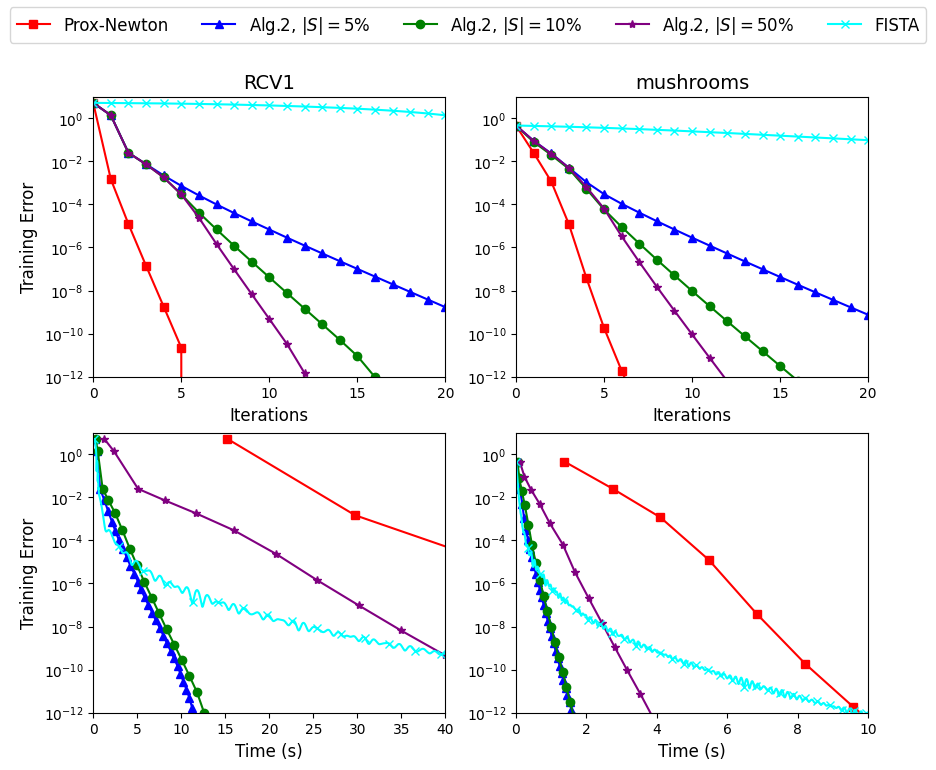

In [82]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(loss_rcv_newton-loss_rcv_star, color='red', marker='s', label='Prox-Newton', markersize=6, markevery=1)
ax[0, 0].plot(loss_rcv_sub_1-loss_rcv_star, color='blue', marker='^', label=r'Alg.2, $|S|=5\%$', markersize=6, markevery=1)
ax[0, 0].plot(loss_rcv_sub_2-loss_rcv_star, color='green', marker='o', label=r'Alg.2, $|S|=10\%$', markersize=6, markevery=1)
ax[0, 0].plot(loss_rcv_sub_3-loss_rcv_star, color='purple', marker='*', label=r'Alg.2, $|S|=50\%$', markersize=6, markevery=1)
ax[0, 0].plot(loss_rcv_fista-loss_rcv_star, color='cyan', marker='x', label='FISTA', markersize=6, markevery=1)
# ax[0, 0].plot(loss_rcv_sub_grow-loss_rcv_star, color='cyan', marker='x', label='sub_grow', markersize=6, markevery=2)
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylim(10**(-12), 10)
# ax[0, 0].legend(fontsize=11)
ax[0, 0].set_ylabel('Training Error', fontsize=12)
ax[0, 0].set_xlabel('Iterations', fontsize=12)
ax[0, 0].set_title('RCV1', fontsize=14)
ax[0, 0].set_xlim(0, 20)
ax[0, 0].set_xticks([0, 5, 10, 15, 20])
ax[0, 1].plot(loss_mush_newton-loss_mush_star, color='red', marker='s', markersize=6, markevery=1)
ax[0, 1].plot(loss_mush_sub_1-loss_mush_star, color='blue', marker='^', markersize=6, markevery=1)
ax[0, 1].plot(loss_mush_sub_2-loss_mush_star, color='green', marker='o', markersize=6, markevery=1)
ax[0, 1].plot(loss_mush_sub_3-loss_mush_star, color='purple', marker='*', markersize=6, markevery=1)
ax[0, 1].plot(loss_mush_fista-loss_mush_star, color='cyan', marker='x', markersize=6, markevery=1)
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylim(10**(-12), 10)
# ax[0, 1].legend(fontsize=11)
ax[0, 1].set_title('mushrooms', fontsize=14)
ax[0, 1].set_xlabel('Iterations', fontsize=12)
ax[0, 1].set_xlim(0, 20)
ax[0, 1].set_xticks([0, 5, 10, 15, 20])
ax[1, 0].plot(time_rcv_newton, loss_rcv_newton-loss_rcv_star, color='red', marker='s', markersize=6, markevery=1)
ax[1, 0].plot(time_rcv_sub_1, loss_rcv_sub_1-loss_rcv_star, color='blue', marker='^', markersize=6, markevery=1)
ax[1, 0].plot(time_rcv_sub_2, loss_rcv_sub_2-loss_rcv_star, color='green', marker='o', markersize=6, markevery=1)
ax[1, 0].plot(time_rcv_sub_3, loss_rcv_sub_3-loss_rcv_star, color='purple', marker='*', markersize=6, markevery=1)
ax[1, 0].plot(time_rcv_fista[:5000], loss_rcv_fista[:5000]-loss_rcv_star, color='cyan', marker='x', markersize=6, markevery=200)
ax[1, 0].set_ylabel('Training Error', fontsize=12)
# ax[1, 0].legend()
ax[1, 0].set_yscale('log')
ax[1, 0].set_xlim(0, 40)
ax[1, 0].set_ylim(10**(-12), 10)
ax[1, 0].set_xlabel('Time (s)', fontsize=12)
ax[1, 1].plot(time_mush_newton, loss_mush_newton-loss_mush_star, color='red', marker='s', markersize=6, markevery=1)
ax[1, 1].plot(time_mush_sub_1, loss_mush_sub_1-loss_mush_star, color='blue', marker='^', markersize=6, markevery=1)
ax[1, 1].plot(time_mush_sub_2, loss_mush_sub_2-loss_mush_star, color='green', marker='o', markersize=6, markevery=1)
ax[1, 1].plot(time_mush_sub_3, loss_mush_sub_3-loss_mush_star, color='purple', marker='*', markersize=6, markevery=1)
ax[1, 1].plot(time_mush_fista, loss_mush_fista-loss_mush_star, color='cyan', marker='x', markersize=6, markevery=200)
ax[1, 1].set_yscale('log')
ax[1, 1].set_ylim(10**(-12), 10)
# ax[1, 1].legend()
ax[1, 1].set_xlabel('Time (s)', fontsize=12)
ax[1, 1].set_xlim(0, 10)
# apply seaborn style
# plt.style.use('seaborn')
fig.legend(loc='upper center', ncol=5, fontsize=12)
# plt.savefig('images/real_dataset_test.png')
plt.show()

### Testing error on a9a and w8a

In [60]:
from functools import partial
test_a9a = partial(F_logistic, X=X_a9a_t, y=y_a9a_t, lam=0, mu=1e-3)
test_a9a_fista = np.apply_along_axis(test_a9a, axis=1, arr=x_a9a_fista)
test_a9a_newton = np.apply_along_axis(test_a9a, axis=1, arr=x_a9a_newton)
test_a9a_sub_2 = np.apply_along_axis(test_a9a, axis=1, arr=x_a9a_sub_2)

test_w8a = partial(F_logistic, X=X_w8a_t, y=y_w8a_t, lam=0, mu=1e-3)
test_w8a_fista = np.apply_along_axis(test_w8a, axis=1, arr=x_w8a_fista)
test_w8a_newton = np.apply_along_axis(test_w8a, axis=1, arr=x_w8a_newton)
test_w8a_sub_2 = np.apply_along_axis(test_w8a, axis=1, arr=x_w8a_sub_2)

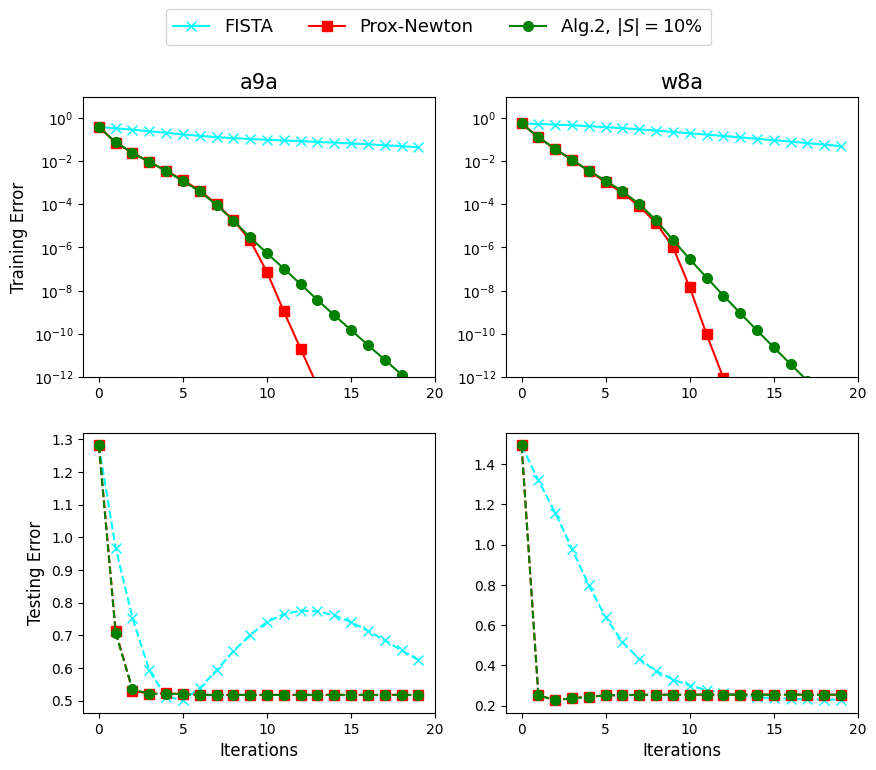

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(loss_a9a_fista[:20]-loss_a9a_star, label='FISTA', color='cyan', marker='x', markersize=7, markevery=1)
ax[0, 0].plot(loss_a9a_newton-loss_a9a_star, label='Prox-Newton', color='red', marker='s', markersize=7, markevery=1)
ax[0, 0].plot(loss_a9a_sub_2-loss_a9a_star, label=r'Alg.2, $|S|=10\%$', color='green', marker='o', markersize=7, markevery=1)
# ax[0, 0].legend(fontsize=11)
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylim(10**(-12), 10)
ax[0, 0].set_ylabel('Training Error', fontsize=12)
ax[0, 0].set_xticks([0, 5, 10, 15, 20])
ax[0, 0].set_title('a9a', fontsize=15)
ax[0, 1].plot(loss_w8a_fista[:20]-loss_w8a_star, color='cyan', marker='x', markersize=7, markevery=1)
ax[0, 1].plot(loss_w8a_newton-loss_w8a_star, color='red', marker='s', markersize=7, markevery=1)
ax[0, 1].plot(loss_w8a_sub_2-loss_w8a_star, color='green', marker='o', markersize=7, markevery=1)
# ax[0, 1].legend(fontsize=11)
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylim(10**(-12), 10)
ax[0, 1].set_title('w8a', fontsize=15)
ax[0, 1].set_xticks([0, 5, 10, 15, 20])
# ax[0, 1].set_ylabel('Training Error', fontsize=12)
ax[1, 0].plot(test_a9a_fista[:20], linestyle='dashed', color='cyan', marker='x', markersize=7, markevery=1)
ax[1, 0].plot(test_a9a_newton, linestyle='dashed', color='red', marker='s', markersize=7, markevery=1)
ax[1, 0].plot(test_a9a_sub_2, linestyle='dashed', color='green', marker='o', markersize=7, markevery=1)
# ax[1, 0].legend(fontsize=11)
# ax[1, 0].set_yscale('log')
ax[1, 0].set_xlabel('Iterations', fontsize=12)
ax[1, 0].set_ylabel('Testing Error', fontsize=12)
ax[1, 0].set_xticks([0, 5, 10, 15, 20])
ax[1, 1].plot(test_w8a_fista[:20], linestyle='dashed', color='cyan', marker='x', markersize=7, markevery=1)
ax[1, 1].plot(test_w8a_newton, linestyle='dashed', color='red', marker='s', markersize=7, markevery=1)
ax[1, 1].plot(test_w8a_sub_2, linestyle='dashed', color='green', marker='o', markersize=7, markevery=1)
# ax[1, 1].legend(fontsize=11)
# ax[1, 1].set_yscale('log')
ax[1, 1].set_xlabel('Iterations', fontsize=12)
# ax[1, 1].set_ylabel('Testing Error', fontsize=12)
ax[1, 1].set_xticks([0, 5, 10, 15, 20])
fig.legend(loc='upper center', ncol=3, fontsize=13)
plt.savefig('images/a9a_w8a_generalization_error.png')
plt.show()

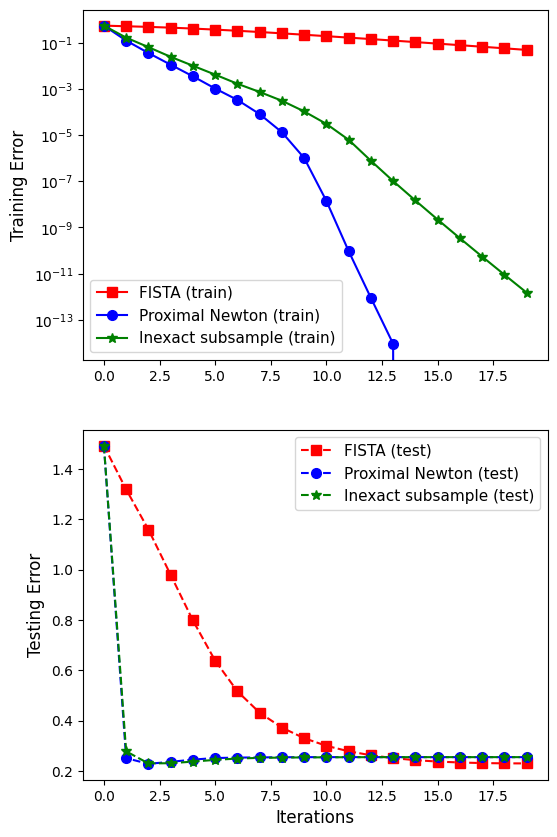

In [ ]:
# fig, ax = plt.subplots(2, 1, figsize=(6, 10))
# ax[0].plot(loss_w8a_fista-loss_w8a_star, label='FISTA (train)', color='red', marker='s', markersize=7, markevery=1)
# ax[0].plot(loss_w8a_newton-loss_w8a_star, label='Proximal Newton (train)', color='blue', marker='o', markersize=7, markevery=1)
# ax[0].plot(loss_w8a_sub_2-loss_w8a_star, label='Inexact subsample (train)', color='green', marker='*', markersize=7, markevery=1)
# ax[0].legend(fontsize=11)
# ax[0].set_yscale('log')
# ax[0].set_ylabel('Training Error', fontsize=12)
# ax[1].plot(test_w8a_fista, label='FISTA (test)', linestyle='dashed', color='red', marker='s', markersize=7, markevery=1)
# ax[1].plot(test_w8a_newton, label='Proximal Newton (test)', linestyle='dashed', color='blue', marker='o', markersize=7, markevery=1)
# ax[1].plot(test_w8a_sub_2, label='Inexact subsample (test)', linestyle='dashed', color='green', marker='*', markersize=7, markevery=1)
# ax[1].legend(fontsize=11)
# # ax[1].set_yscale('log')
# ax[1].set_xlabel('Iterations', fontsize=12)
# ax[1].set_ylabel('Testing Error', fontsize=12)
# plt.savefig('images/w8a_generalization_error.png')
# plt.show()

In [70]:
# test accuracy
from sklearn.metrics import accuracy_score

def predict_label(w, X):
    Z = X.dot(w)
    sigmoid = 1 / (1 + np.exp(-Z))
    prediction = sigmoid > 0.5
    return prediction.astype(int)

def test_accuracy(w, X, y):
    prediction = predict_label(w, X)
    return accuracy_score(y, prediction)

acc_a9a = partial(test_accuracy, X=X_a9a_t, y=y_a9a_t)
acc_a9a_fista = np.apply_along_axis(acc_a9a, axis=1, arr=x_a9a_fista)
acc_a9a_newton = np.apply_along_axis(acc_a9a, axis=1, arr=x_a9a_newton)
acc_a9a_sub_2 = np.apply_along_axis(acc_a9a, axis=1, arr=x_a9a_sub_2)

acc_w8a = partial(test_accuracy, X=X_w8a_t, y=y_w8a_t)
acc_w8a_fista = np.apply_along_axis(acc_w8a, axis=1, arr=x_w8a_fista)
acc_w8a_newton = np.apply_along_axis(acc_w8a, axis=1, arr=x_w8a_newton)
acc_w8a_sub_2 = np.apply_along_axis(acc_w8a, axis=1, arr=x_w8a_sub_2)

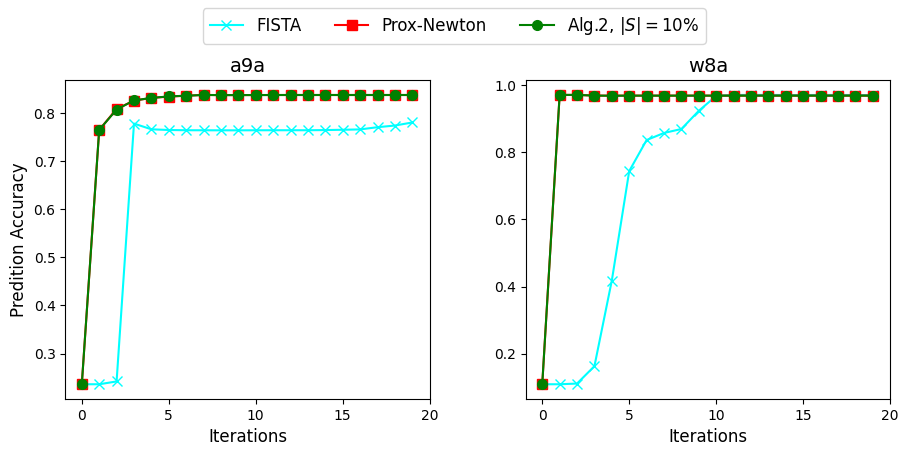

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(acc_a9a_fista[:20], label='FISTA', color='cyan', marker='x', markersize=7, markevery=1)
ax[0].plot(acc_a9a_newton, label='Prox-Newton', color='red', marker='s', markersize=7, markevery=1)
ax[0].plot(acc_a9a_sub_2, label=r'Alg.2, $|S|=10\%$', color='green', marker='o', markersize=7, markevery=1)
# ax[0].set_ylim(10**(-12), 10)
ax[0].set_ylabel('Predition Accuracy', fontsize=12)
ax[0].set_xlabel('Iterations', fontsize=12)
ax[0].set_xticks([0, 5, 10, 15, 20])
ax[0].set_title('a9a', fontsize=14)
ax[1].plot(acc_w8a_fista[:20], color='cyan', marker='x', markersize=7, markevery=1)
ax[1].plot(acc_w8a_newton, color='red', marker='s', markersize=7, markevery=1)
ax[1].plot(acc_w8a_sub_2, color='green', marker='o', markersize=7, markevery=1)
ax[1].set_title('w8a', fontsize=14)
ax[1].set_xticks([0, 5, 10, 15, 20])
ax[1].set_xlabel('Iterations', fontsize=12)
fig.legend(loc='upper center', ncol=3, fontsize=12)
# 调整子图布局并设置距离
fig.tight_layout(pad=4.0)
plt.savefig('images/a9a_w8a_prediction_accuracy.png')

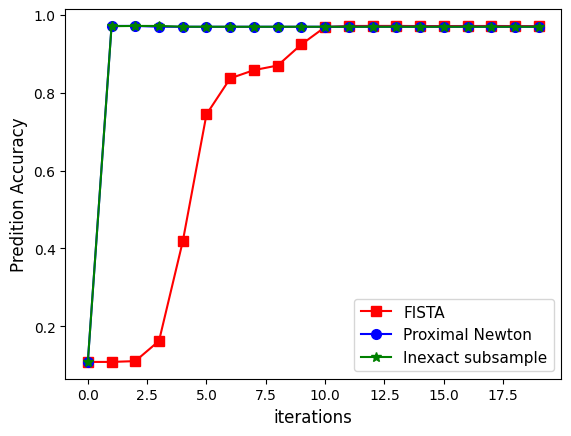

In [ ]:
plt.plot(acc_w8a_fista, label='FISTA', color='red', marker='s', markersize=7, markevery=1)
plt.plot(acc_w8a_newton, label='Proximal Newton', color='blue', marker='o', markersize=7, markevery=1)
plt.plot(acc_w8a_sub_2, label='Inexact subsample', color='green', marker='*', markersize=7, markevery=1)
plt.legend(fontsize =11)
plt.xlabel('iterations', fontsize=12)
plt.ylabel('Predition Accuracy', fontsize = 12)
plt.savefig('images/w8a_accuracy.png')
plt.show()